In [1]:
import numpy as np
import cupy as cp
import sys
import pandas as pd
import time
# import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import h5py
from utils import *

# Init data sizes and parametes of the PXM of ID16A

In [2]:
th = "3920"
path = f'/data/visitors/danmax/20241507/2025060408/viktor/ca_{th}/'
npos=225
ids = np.arange(npos)
# for k in range(15):    
#     if k%2==1:
#         ids[k*15:(k+1)*15] = ids[k*15:(k+1)*15][::-1]
# ids = ids[::15]
with  h5py.File(f'{path}/data_ca.h5','r') as fid:
    data = fid[f'/exchange/pdata'][ids].astype('float32')
    ref = fid[f'/exchange/pref'][:].astype('float32')
    shifts = fid[f'/exchange/shifts'][ids].astype('float32')    
    
    z1 = fid['/exchange/z1'][0]
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]
    energy = fid['/exchange/energy'][0]


In [3]:
wavelength = 1.24e-09/energy  # [m] wave length
# focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  # object voxel size


In [4]:
print(energy,z1,distances,voxelsize)
n = 2048
npsi = 2048+2048


19.55 0.527 0.4301257 1.0110224e-07


In [5]:
rdata = np.array(data / (ref + 1e-5))


In [6]:
# for k in range(npos):
    # mshow(rdata[k],True)

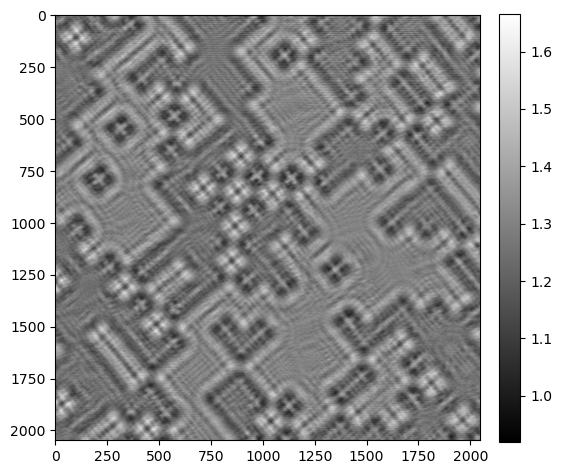

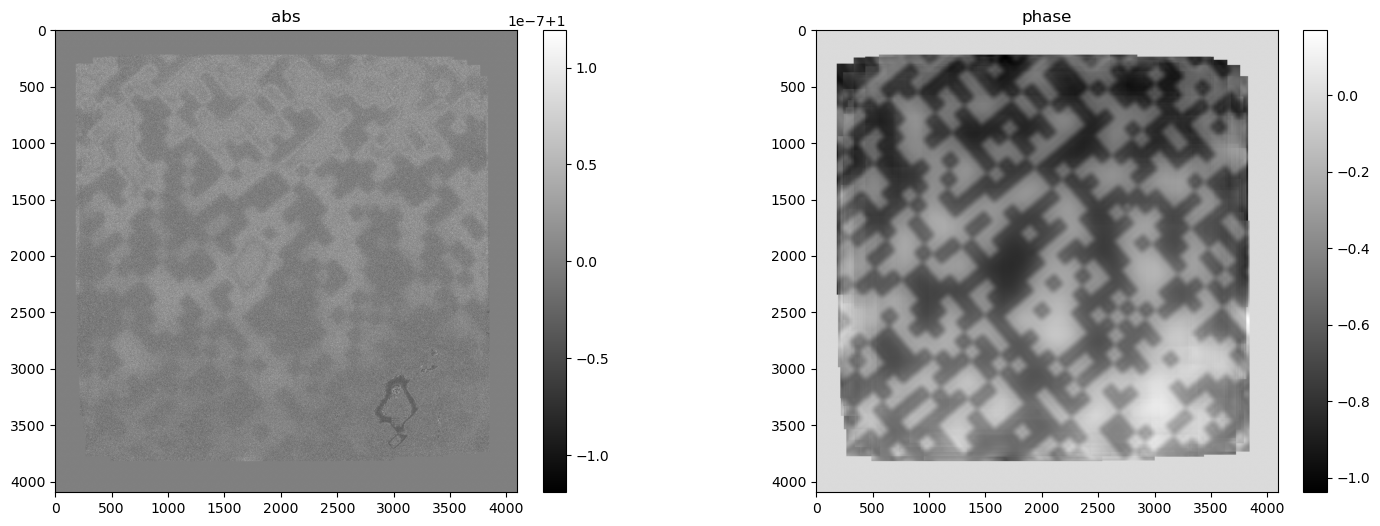

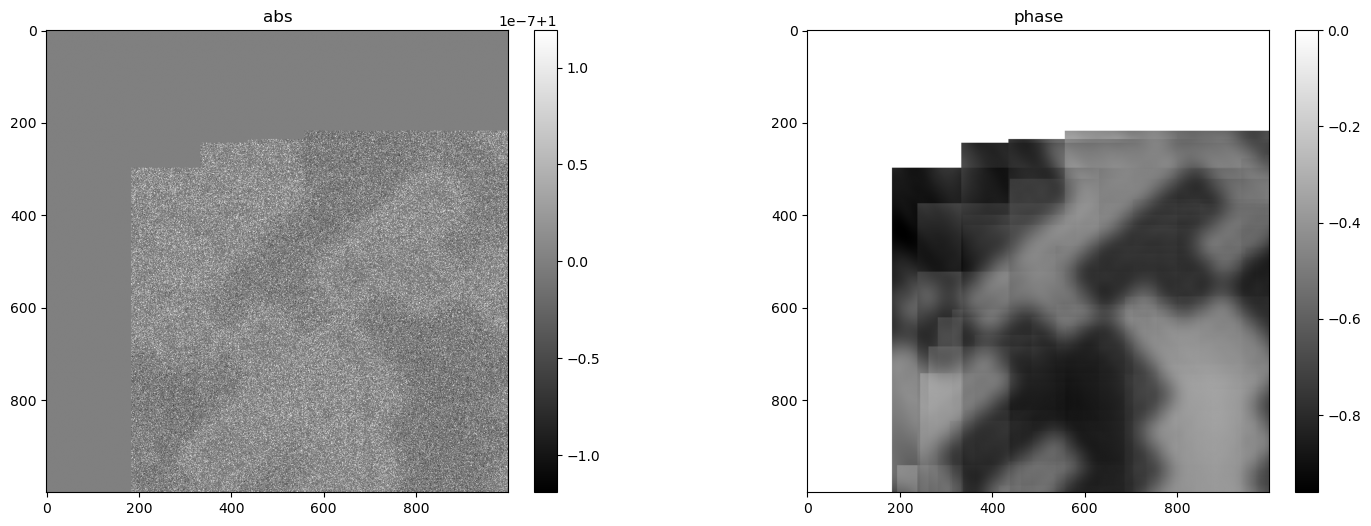

In [7]:
def Paganin(data, wavelength, voxelsize, delta_beta, alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distances * cp.pi * (delta_beta) * (fx**2 + fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    return phase


def rec_init(rdata, ishifts):
    recMultiPaganin = cp.zeros([npsi, npsi], dtype="float32")
    recMultiPaganinr = cp.zeros(
        [npsi, npsi], dtype="float32"
    )  # to compensate for overlap
    for j in range(0, npos):
        r = cp.array(rdata[j])
        r = Paganin(r, wavelength, voxelsize, 50.05, 1e-3)
        # mshow(r,True)
        rr = r * 0 + 1  # to compensate for overlap
        rpsi = cp.zeros([npsi, npsi], dtype="float32")
        rrpsi = cp.zeros([npsi, npsi], dtype="float32")
        stx = npsi // 2 - ishifts[j, 1] - n // 2
        endx = stx + n
        sty = npsi // 2 - ishifts[j, 0] - n // 2
        endy = sty + n
        rpsi[sty:endy, stx:endx] = r
        rrpsi[sty:endy, stx:endx] = rr
        # mshow(rpsi/rrpsi,True)
        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi

    recMultiPaganinr[np.abs(recMultiPaganinr) < 5e-2] = 1
    recMultiPaganin /= recMultiPaganinr
    recMultiPaganin = np.exp(1j * recMultiPaganin)
    return recMultiPaganin


ishifts = np.round(np.array(shifts)).astype("int32")
rdata = np.array(data / (ref + 1e-5))
mshow(rdata[0],True)
psi_init = rec_init(rdata, ishifts)
mshow_polar(psi_init,True)
mshow_polar(psi_init[:1000, :1000],True)

# smooth borders
# v = cp.arange(-npsi // 2,npsi // 2) / npsi
# [vx, vy] = cp.meshgrid(v, v)
# v = cp.exp(-1000 * (vx**2 + vy**2)).astype("float32")

# psi_init = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(psi_init)))
# psi_init = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(psi_init * v))).astype(
#     "complex64"
# )
# mshow_polar(psi_init,True)
# mshow_polar(psi_init[:1000, :1000],True)


In [8]:
print(distances,voxelsize,energy)


0.4301257 1.0110224e-07 19.55


In [9]:
path_out = f'/data/visitors/danmax/20241507/2025060408/viktor/ca_{th}/'
with  h5py.File(f'{path_out}/data_ca.h5','a') as fid:
    try:
        del fid[f'/exchange/psi_init']
    except:
        pass
    fid.create_dataset(f'/exchange/psi_init',data=psi_init.get())     